In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import glob
from astropy.io import fits
import matplotlib.colors as col
import time

In [4]:
def progress(file_count, total_files):
    print("\tFiles Completed: {}/{}".format(file_count, total_files), end="\r") 
    time.sleep(1)

File Number 1/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 1.0 Myr - 30 MHz
Time index: 1.0
FITS Image Dimensions: 48x48 pixels 



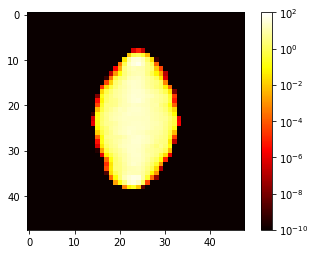



Quadrupol moment:

 [[ 0.97558341 -0.05644518]
 [-0.05644518 -0.97558341]]


Octupolpol moment:

 [[[-0.05795449 -0.06338535]
  [-0.06338535 -0.04934266]]

 [[-0.06338535 -0.04934266]
  [-0.04934266  0.19874528]]]


Hexadecapol moment:

 [[[[ 3.63279812 -0.44842159]
   [-0.44842159 -3.63279812]]

  [[-0.44842159 -3.63279812]
   [-3.63279812  0.44842159]]]


 [[[-0.44842159 -3.63279812]
   [-3.63279812  0.44842159]]

  [[-3.63279812  0.44842159]
   [ 0.44842159  3.63279812]]]]
____________________________________________________________________________________________________

File Number 2/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 2.0 Myr - 30 MHz
Time index: 2.0
FITS Image Dimensions: 80x80 pixels 



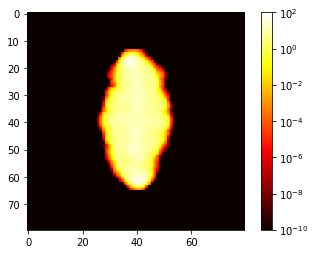



Quadrupol moment:

 [[ 1.30826124  0.05277804]
 [ 0.05277804 -1.30826124]]


Octupolpol moment:

 [[[ 0.65286998 -0.11358984]
  [-0.11358984  0.56232561]]

 [[-0.11358984  0.56232561]
  [ 0.56232561  0.38315166]]]


Hexadecapol moment:

 [[[[ 5.30702801  0.91189773]
   [ 0.91189773 -5.30702801]]

  [[ 0.91189773 -5.30702801]
   [-5.30702801 -0.91189773]]]


 [[[ 0.91189773 -5.30702801]
   [-5.30702801 -0.91189773]]

  [[-5.30702801 -0.91189773]
   [-0.91189773  5.30702801]]]]
____________________________________________________________________________________________________

File Number 3/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 4.0 Myr - 30 MHz
Time index: 4.0
FITS Image Dimensions: 144x144 pixels 



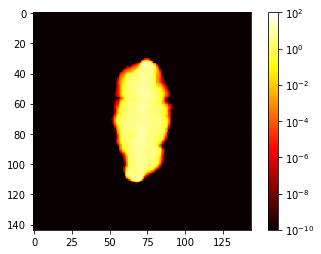



Quadrupol moment:

 [[ 0.94710146 -0.08274027]
 [-0.08274027 -0.94710146]]


Octupolpol moment:

 [[[ 0.08785728 -0.01134023]
  [-0.01134023  0.11086331]]

 [[-0.01134023  0.11086331]
  [ 0.11086331  0.05456116]]]


Hexadecapol moment:

 [[[[ 2.78679101 -0.70768863]
   [-0.70768863 -2.78679101]]

  [[-0.70768863 -2.78679101]
   [-2.78679101  0.70768863]]]


 [[[-0.70768863 -2.78679101]
   [-2.78679101  0.70768863]]

  [[-2.78679101  0.70768863]
   [ 0.70768863  2.78679101]]]]
____________________________________________________________________________________________________

File Number 4/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 8.0 Myr - 30 MHz
Time index: 8.0
FITS Image Dimensions: 240x240 pixels 



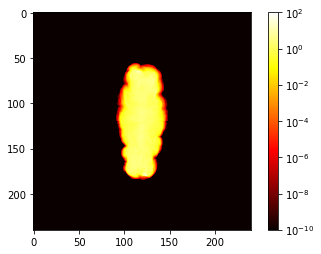



Quadrupol moment:

 [[ 0.96198717 -0.08286794]
 [-0.08286794 -0.96198717]]


Octupolpol moment:

 [[[-0.17196064 -0.06181884]
  [-0.06181884 -0.18457352]]

 [[-0.06181884 -0.18457352]
  [-0.18457352  0.19792403]]]


Hexadecapol moment:

 [[[[ 2.2953941  -0.26358746]
   [-0.26358746 -2.2953941 ]]

  [[-0.26358746 -2.2953941 ]
   [-2.2953941   0.26358746]]]


 [[[-0.26358746 -2.2953941 ]
   [-2.2953941   0.26358746]]

  [[-2.2953941   0.26358746]
   [ 0.26358746  2.2953941 ]]]]
____________________________________________________________________________________________________

File Number 5/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 16.0 Myr - 30 MHz
Time index: 16.0
FITS Image Dimensions: 400x400 pixels 



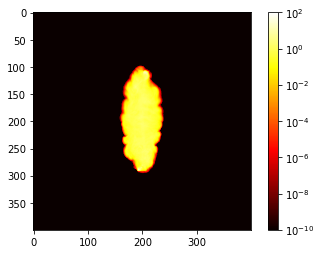



Quadrupol moment:

 [[ 0.65371922  0.01613423]
 [ 0.01613423 -0.65371922]]


Octupolpol moment:

 [[[0.06952553 0.00731911]
  [0.00731911 0.05826877]]

 [[0.00731911 0.05826877]
  [0.05826877 0.00064004]]]


Hexadecapol moment:

 [[[[ 1.34202738 -0.01223375]
   [-0.01223375 -1.34202738]]

  [[-0.01223375 -1.34202738]
   [-1.34202738  0.01223375]]]


 [[[-0.01223375 -1.34202738]
   [-1.34202738  0.01223375]]

  [[-1.34202738  0.01223375]
   [ 0.01223375  1.34202738]]]]
____________________________________________________________________________________________________

File Number 6/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 32.0 Myr - 30 MHz
Time index: 32.0
FITS Image Dimensions: 560x560 pixels 



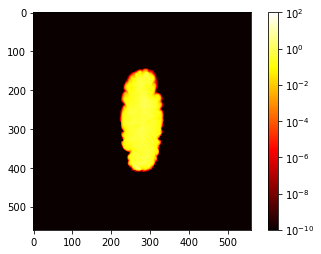



Quadrupol moment:

 [[ 0.58876619 -0.02170041]
 [-0.02170041 -0.58876619]]


Octupolpol moment:

 [[[-0.31957533  0.00601887]
  [ 0.00601887 -0.27779651]]

 [[ 0.00601887 -0.27779651]
  [-0.27779651  0.00134837]]]


Hexadecapol moment:

 [[[[ 1.09298281 -0.10866345]
   [-0.10866345 -1.09298281]]

  [[-0.10866345 -1.09298281]
   [-1.09298281  0.10866345]]]


 [[[-0.10866345 -1.09298281]
   [-1.09298281  0.10866345]]

  [[-1.09298281  0.10866345]
   [ 0.10866345  1.09298281]]]]
____________________________________________________________________________________________________

File Number 7/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 64.0 Myr - 30 MHz
Time index: 64.0
FITS Image Dimensions: 720x720 pixels 



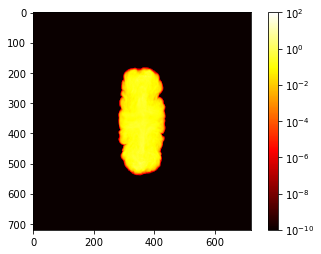



Quadrupol moment:

 [[ 0.72165752 -0.01950238]
 [-0.01950238 -0.72165752]]


Octupolpol moment:

 [[[-0.43479079 -0.03907259]
  [-0.03907259 -0.36554807]]

 [[-0.03907259 -0.36554807]
  [-0.36554807  0.16108709]]]


Hexadecapol moment:

 [[[[ 1.36982018 -0.09564412]
   [-0.09564412 -1.36982018]]

  [[-0.09564412 -1.36982018]
   [-1.36982018  0.09564412]]]


 [[[-0.09564412 -1.36982018]
   [-1.36982018  0.09564412]]

  [[-1.36982018  0.09564412]
   [ 0.09564412  1.36982018]]]]
____________________________________________________________________________________________________

File Number 8/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 128.0 Myr - 30 MHz
Time index: 128.0
FITS Image Dimensions: 976x976 pixels 



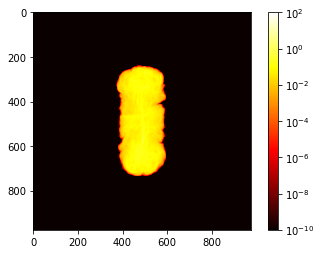



Quadrupol moment:

 [[ 0.89780109 -0.0113043 ]
 [-0.0113043  -0.89780109]]


Octupolpol moment:

 [[[-0.21808808 -0.01789089]
  [-0.01789089 -0.19340033]]

 [[-0.01789089 -0.19340033]
  [-0.19340033  0.0667944 ]]]


Hexadecapol moment:

 [[[[ 1.66164027 -0.10942079]
   [-0.10942079 -1.66164027]]

  [[-0.10942079 -1.66164027]
   [-1.66164027  0.10942079]]]


 [[[-0.10942079 -1.66164027]
   [-1.66164027  0.10942079]]

  [[-1.66164027  0.10942079]
   [ 0.10942079  1.66164027]]]]
____________________________________________________________________________________________________

File Number 9/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 256.0 Myr - 30 MHz
Time index: 256.0
FITS Image Dimensions: 1584x1584 pixels 



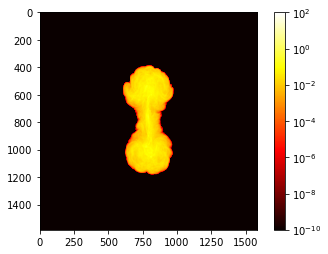



Quadrupol moment:

 [[ 0.91511629  0.01719332]
 [ 0.01719332 -0.91511629]]


Octupolpol moment:

 [[[0.45871064 0.00808939]
  [0.00808939 0.39426211]]

 [[0.00808939 0.39426211]
  [0.39426211 0.00176796]]]


Hexadecapol moment:

 [[[[ 1.4589217   0.02922362]
   [ 0.02922362 -1.4589217 ]]

  [[ 0.02922362 -1.4589217 ]
   [-1.4589217  -0.02922362]]]


 [[[ 0.02922362 -1.4589217 ]
   [-1.4589217  -0.02922362]]

  [[-1.4589217  -0.02922362]
   [-0.02922362  1.4589217 ]]]]
____________________________________________________________________________________________________

File Number 10/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 320.0 Myr - 30 MHz
Time index: 320.0
FITS Image Dimensions: 1936x1936 pixels 



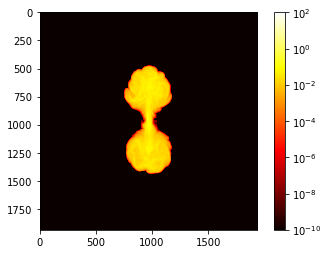



Quadrupol moment:

 [[ 0.91845354  0.00298695]
 [ 0.00298695 -0.91845354]]


Octupolpol moment:

 [[[ 0.57811427  0.01770368]
  [ 0.01770368  0.50509782]]

 [[ 0.01770368  0.50509782]
  [ 0.50509782 -0.02992804]]]


Hexadecapol moment:

 [[[[ 1.53025292  0.03753086]
   [ 0.03753086 -1.53025292]]

  [[ 0.03753086 -1.53025292]
   [-1.53025292 -0.03753086]]]


 [[[ 0.03753086 -1.53025292]
   [-1.53025292 -0.03753086]]

  [[-1.53025292 -0.03753086]
   [-0.03753086  1.53025292]]]]
____________________________________________________________________________________________________

File Number 11/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 384.0 Myr - 30 MHz
Time index: 384.0
FITS Image Dimensions: 2384x2384 pixels 



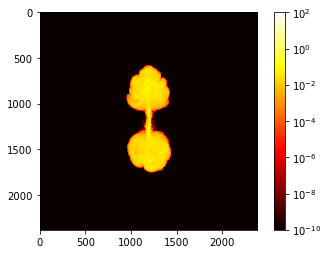



Quadrupol moment:

 [[ 0.97453369  0.05966164]
 [ 0.05966164 -0.97453369]]


Octupolpol moment:

 [[[ 0.11723349  0.05440259]
  [ 0.05440259  0.20599167]]

 [[ 0.05440259  0.20599167]
  [ 0.20599167 -0.19307361]]]


Hexadecapol moment:

 [[[[ 1.65155234  0.22896516]
   [ 0.22896516 -1.65155234]]

  [[ 0.22896516 -1.65155234]
   [-1.65155234 -0.22896516]]]


 [[[ 0.22896516 -1.65155234]
   [-1.65155234 -0.22896516]]

  [[-1.65155234 -0.22896516]
   [-0.22896516  1.65155234]]]]
____________________________________________________________________________________________________

File Number 12/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 512.1 Myr - 30 MHz
Time index: 512.1
FITS Image Dimensions: 3152x3152 pixels 



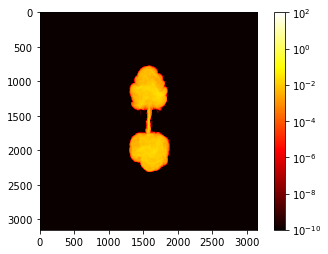



Quadrupol moment:

 [[ 0.91859322  0.03577351]
 [ 0.03577351 -0.91859322]]


Octupolpol moment:

 [[[-0.1894992   0.06308908]
  [ 0.06308908 -0.09778629]]

 [[ 0.06308908 -0.09778629]
  [-0.09778629 -0.23485211]]]


Hexadecapol moment:

 [[[[ 1.42927822  0.18916088]
   [ 0.18916088 -1.42927822]]

  [[ 0.18916088 -1.42927822]
   [-1.42927822 -0.18916088]]]


 [[[ 0.18916088 -1.42927822]
   [-1.42927822 -0.18916088]]

  [[-1.42927822 -0.18916088]
   [-0.18916088  1.42927822]]]]
____________________________________________________________________________________________________

File Number 13/13

Simulation Title: Simulation Group_L446_rc100_beta07 - 998.1 Myr - 30 MHz
Time index: 998.1
FITS Image Dimensions: 5232x5232 pixels 



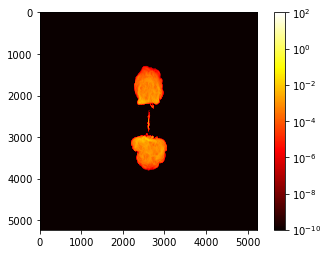



Quadrupol moment:

 [[ 0.72291495  0.00517415]
 [ 0.00517415 -0.72291495]]


Octupolpol moment:

 [[[-0.18390529  0.01881236]
  [ 0.01881236 -0.00670923]]

 [[ 0.01881236 -0.00670923]
  [-0.00670923 -0.04265344]]]


Hexadecapol moment:

 [[[[ 0.86112154  0.0964715 ]
   [ 0.0964715  -0.86112154]]

  [[ 0.0964715  -0.86112154]
   [-0.86112154 -0.0964715 ]]]


 [[[ 0.0964715  -0.86112154]
   [-0.86112154 -0.0964715 ]]

  [[-0.86112154 -0.0964715 ]
   [-0.0964715   0.86112154]]]]
____________________________________________________________________________________________________

        0             1             2           3             4             5  \
0    Time  Quad Value 1  Quad Value 2  Quad Ratio  Hexa Value 1  Hexa Value 2   
1     1.0        0.9756       -0.0564    -17.2837        3.6328       -0.4484   
2     2.0        1.3083        0.0528      24.788         5.307        0.9119   
3     4.0        0.9471       -0.0827    -11.4467        2.7868       -0.7077   
4     8.0 

In [2]:
#JET RESEMBLENSE
cen = 250

ratio_data = np.array([["Time", "Quad Value 1", "Quad Value 2", "Quad Ratio", "Hexa Value 1", "Hexa Value 2", "Hexa Ratio", "Octo Value 1", "Octo Value 2"]])

path = '**/Group_L446_rc100_*nu=30.0*0.00_1.00_0.00*Myr.fits*'


# Determines if there are any files in device
total_files = len(glob.glob(path, recursive=True))

if total_files > 0:
    file_count = 0
    for file in sorted(glob.glob(path, recursive=True)):

        file_count += 1

        try:
            print("File Number {}/{}\n".format(file_count, total_files))
            #print("File Name: {}".format(file))
            fits_image_hdul = fits.open(file)

            #Displays FITS Image title, time index, and pixel size
            sim_title = fits_image_hdul[0].header['OBJECT']
            sim_time = fits_image_hdul[0].header['TIME']
            sim_time = round(float(sim_time[:-4]), 1)
            
            
            pixel = fits_image_hdul[0].header['CDELT1']
            print("Simulation Title: {}".format(sim_title))
            print("Time index: {}".format(sim_time))
            #print("Pixel size: {}".format(pixel))
            pixel_size = float(pixel[:-3])

            #Difines Data From FITS image and records image dimensions
            data =  fits_image_hdul[0].data
            length = len(data[0])
            width = len(data)
            print("FITS Image Dimensions: {}x{} pixels \n".format(length, width))
            
            #hdr = fits_image_hdul[0].header
            #header = repr(hdr)
            #print(header)

            nx=length
            ny=width
            x=np.outer(np.linspace(-5,5,nx),np.ones(ny))
            y=np.outer(np.ones(nx),np.linspace(-5,5,ny))
            img=data
            
            image_data = fits.getdata(file, ext=0)
            for i in range(image_data.shape[0]):
                for j in range(image_data.shape[1]):
                    if image_data[i, j] == 0:
                        image_data[i, j] = 1e-12


            plt.figure()
            plt.imshow(image_data, cmap='hot', norm=col.LogNorm())
            plt.clim(10e-11, 1e2) 
            plt.colorbar() 
            plt.show()
            
            # Quadruple moment:
            rsqr=x**2 + y**2
            q2=np.zeros([2,2])
            xy=[x,y]
            for i in [0,1]:
                for j in [0,1]:
                    if i==j:
                        dij=1
                    else:
                        dij=0
                    q2[i,j]=1./2.*np.sum(img*(2*xy[i]*xy[j] - rsqr*dij))
            print("\n\nQuadrupol moment:\n\n",q2/np.sum(img))

            q2_norm = q2/np.sum(img)


            # Octupole moment:

            q3=np.zeros([2,2,2])
            xy=[x,y]
            for i in [0,1]:
                for j in [0,1]:
                    if i==j:
                        dij=1
                    else:
                        dij=0
                    for k in [0,1]:
                        if i==k:
                            dik=1
                        else:
                            dik=0
                        if j==k:
                            djk=1
                        else:
                            djk=0
                        q3[i,j,k]=1./2.*np.sum(img*(4*xy[i]*xy[j]*xy[k])) - np.sum(img*(rsqr*(xy[i]*djk + xy[j]*dik + xy[k]*dij)))

            q3_norm = q3/np.sum(img)
            print("\n\nOctupolpol moment:\n\n",q3_norm)




            # Hexadecapole moment:

            q4=np.zeros([2,2,2,2])
            xy=[x,y]
            for i in [0,1]:
                for j in [0,1]:
                    if i==j:
                        dij=1
                    else:
                        dij=0
                    for k in [0,1]:
                        if i==k:
                            dik=1
                        else:
                            dik=0
                        if j==k:
                            djk=1
                        else:
                            djk=0
                        for l in [0,1]:
                            if i==l:
                                dil=1
                            else:
                                dil=0
                            if j==l:
                                djl=1
                            else:
                                djl=0
                            if k==l:
                                dkl=1
                            else:
                                dkl=0
                            q4[i,j,k,l]=1./8.*np.sum(img*(24*xy[i]*xy[j]*xy[k]*xy[l] - 
                                                   4*rsqr*(xy[k]*xy[l]*dij + xy[j]*xy[l]*dik + xy[j]*xy[k]*dil + xy[i]*xy[l]*djk + xy[i]*xy[k]*djl + xy[i]*xy[j]*dkl)) +
                                                   img*(dij*dkl + dik*djl + dil*djk)*rsqr**2)

            print("\n\nHexadecapol moment:\n\n",q4/np.sum(img))
            q4_norm =q4/np.sum(img)

            quad_val1 = q2_norm[0,0]
            quad_val2 = q2_norm[0,1]

            hexa_val1 = q4_norm[0,0,0,0]
            hexa_val2 = q4_norm[0,0,0,1]

            octo_val1 = q3_norm[0,0,1]
            octo_val2 = q3_norm[1,1,1]


            # if quad_val1 < -1e8:
            #     quad_val1 = 0
            # if quad_val2 < -1e8:
            #     quad_val2 = 0
            # if hexa_val1 < -1e8:
            #     hexa_val1 = 0
            # if hexa_val2 < -1e8:
            #     hexa_val2 = 0

            try:
                quad_ratio = round(quad_val1/quad_val2, 4)
            except ZeroDivisionError:
                quad_ratio = np.nan

            try:
                hexa_ratio = round(hexa_val1/hexa_val2, 4)
            except ZeroDivisionError:
                hexa_ratio = np.nan

            if abs(quad_ratio) > 50:
                quad_ratio = np.nan
            if abs(hexa_ratio) > 50:
                hexa_ratio = np.nan

            dis_data = np.array([sim_time, round(quad_val1, 4), round(quad_val2, 4), quad_ratio, round(hexa_val1, 4), round(hexa_val2, 4), hexa_ratio, round(octo_val1, 4), round(octo_val2, 4)])
            ratio_data = np.vstack([ratio_data, dis_data])

            #print("\n\n")


            print("{}\n".format("_"*100))

        except OSError:
            print("Error with file: {}".format(file))
            print("Empty or corrupt FITS file")
            
    data_table = pd.DataFrame(ratio_data)

    print(data_table)   
    
    
else:
    print("ERROR: Could not find any necessary files on your device")
    print("Program intakes files of the name: {}".format(path))





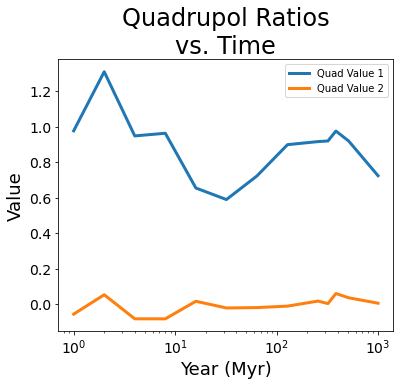

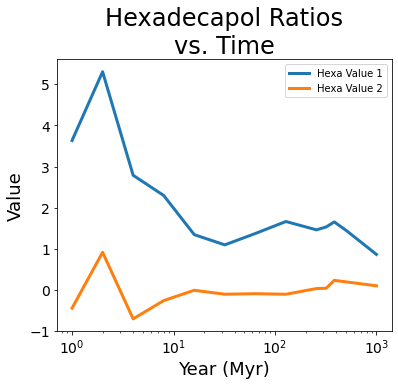

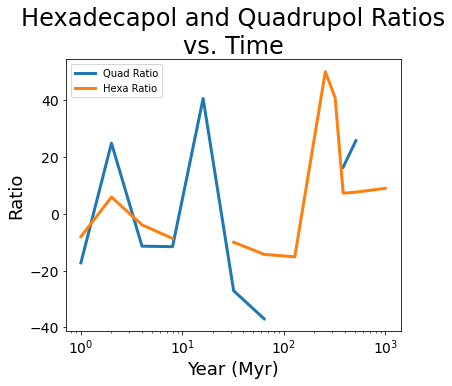

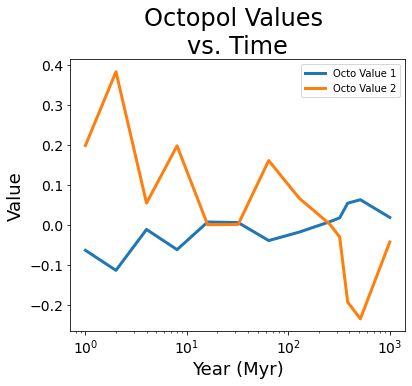

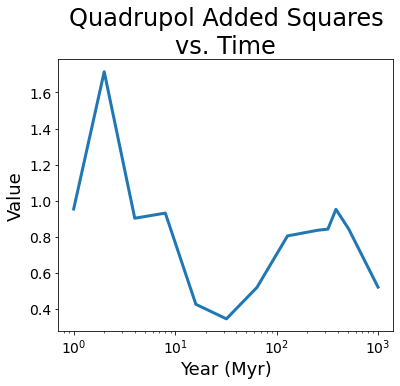

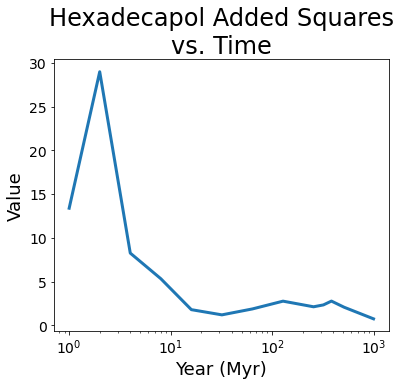

In [3]:
plt.rcParams["figure.figsize"] = (6,5)
rot_vals = ratio_data[1:, 0]
quad1 = ratio_data[1:, 1]
quad2 = ratio_data[1:, 2]
quad_vals = ratio_data[1:, 3]
hexa1 = ratio_data[1:, 4]
hexa2 = ratio_data[1:, 5]
hexa_vals = ratio_data[1:, 6]
octo1 = ratio_data[1:, 7]
octo2 = ratio_data[1:, 8]


rot_vals_flt = []
quad_vals_flt = []
hexa_vals_flt = []
quad1_flt = []
quad2_flt = []
hexa1_flt = []
hexa2_flt = []
octo1_flt = []
octo2_flt = []



for i, ratio in enumerate(quad_vals):
    dispers = float(rot_vals[i])
    ratio = float(ratio)
    rot_vals_flt.append(dispers)
    quad_vals_flt.append(ratio)
    
for ratio in hexa_vals:
    ratio = float(ratio)
    hexa_vals_flt.append(ratio)
    
for ratio in quad1:
    ratio = float(ratio)
    quad1_flt.append(ratio)

for ratio in quad2:
    ratio = float(ratio)
    quad2_flt.append(ratio)
    
for ratio in hexa1:
    ratio = float(ratio)
    hexa1_flt.append(ratio)
    
for ratio in hexa2:
    ratio = float(ratio)
    hexa2_flt.append(ratio)
    
for ratio in octo1:
    ratio = float(ratio)
    octo1_flt.append(ratio)
    
for ratio in octo2:
    ratio = float(ratio)
    octo2_flt.append(ratio)

sq_flt = []
for i in range(len(quad1_flt)):
    sq = quad1_flt[i]**2 + quad2_flt[i]**2
    sq_flt.append(sq)
    
sq_hexa_flt = []
for i in range(len(hexa1_flt)):
    sq = hexa1_flt[i]**2 + hexa2_flt[i]**2
    sq_hexa_flt.append(sq)

abs_quad_vals_flt = [abs(number) for number in quad_vals_flt]
abs_hexa_vals_flt = [abs(number) for number in hexa_vals_flt]

plt.plot(rot_vals_flt, quad1_flt, linewidth=3, label="Quad Value 1")
plt.plot(rot_vals_flt, quad2_flt, linewidth=3, label="Quad Value 2")
plt.xscale("log")
#plt.ylim([-4, 4])
plt.xlabel("Year (Myr)", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Value", fontsize=18)
plt.yticks(fontsize=14)
plt.title("Quadrupol Ratios\nvs. Time", fontsize=24)
plt.legend()
plt.show()

plt.plot(rot_vals_flt, hexa1_flt, linewidth=3, label="Hexa Value 1")
plt.plot(rot_vals_flt, hexa2_flt, linewidth=3, label="Hexa Value 2")
plt.xscale("log")
#plt.ylim([-15, 15])
plt.xlabel("Year (Myr)", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Value", fontsize=18)
plt.yticks(fontsize=14)
plt.title("Hexadecapol Ratios\nvs. Time", fontsize=24)
plt.legend()
plt.show()


plt.plot(rot_vals_flt, quad_vals_flt, linewidth=3, label="Quad Ratio")
plt.plot(rot_vals_flt, hexa_vals_flt, linewidth=3, label="Hexa Ratio")
plt.xscale("log")
#plt.ylim([-15, 15])
plt.xlabel("Year (Myr)", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Ratio", fontsize=18)
plt.yticks(fontsize=14)
plt.title("Hexadecapol and Quadrupol Ratios\nvs. Time", fontsize=24)
plt.legend()
plt.show()


# plt.plot(rot_vals_flt, abs_quad_vals_flt, linewidth=3, label="Quad Ratio")
# plt.plot(rot_vals_flt, abs_hexa_vals_flt, linewidth=3, label="Hexa Ratio")
# plt.xscale("log")
# plt.xlabel("Year (Myr)", fontsize=18)
# plt.xticks(fontsize=14)
# plt.ylabel("Abs. Ratio", fontsize=18)
# plt.yticks(fontsize=14)
# plt.title("Hexadecapol and Quadrupol Ratios\nvs. Time", fontsize=24)
# plt.legend()
# plt.show()


plt.plot(rot_vals_flt, octo1_flt, linewidth=3, label="Octo Value 1")
plt.plot(rot_vals_flt, octo2_flt, linewidth=3, label="Octo Value 2")
plt.xscale("log")
#plt.ylim([-15, 15])
plt.xlabel("Year (Myr)", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Value", fontsize=18)
plt.yticks(fontsize=14)
plt.title("Octopol Values \nvs. Time", fontsize=24)
plt.legend()
plt.show()


plt.plot(rot_vals_flt, sq_flt, linewidth=3)
plt.xscale("log")
plt.xlabel("Year (Myr)", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Value", fontsize=18)
plt.yticks(fontsize=14)
plt.title("Quadrupol Added Squares\nvs. Time", fontsize=24)
#plt.legend()
plt.show()


plt.plot(rot_vals_flt, sq_hexa_flt, linewidth=3)
plt.xscale("log")
plt.xlabel("Year (Myr)", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Value", fontsize=18)
plt.yticks(fontsize=14)
plt.title("Hexadecapol Added Squares\nvs. Time", fontsize=24)
#plt.legend()
plt.show()


# plt.plot(dis_vals_flt[1:], ratio_vals_flt[1:], linewidth=3)
# plt.xlabel("Lobe Dispersion Factor\n(Scalar Change in Distance)", fontsize=18)
# plt.xticks(fontsize=14)
# plt.ylabel("Ratio Hexa:Quad", fontsize=18)
# plt.yticks(fontsize=14)
# plt.title("Hexadecapol:Quadrupol Ratio\nvs. Lobe Separation", fontsize=24)
# plt.show()

# plt.plot(dis_vals_flt[1:], ratio_vals_flt[1:], linewidth=3)
# plt.yscale("log")
# plt.xlabel("Lobe Dispersion Factor\n(Scalar Change in Distance)", fontsize=18)
# plt.xticks(fontsize=14)
# plt.ylabel("Ratio Hexa:Quad", fontsize=18)
# plt.yticks(fontsize=14)
# plt.title("Hexadecapol:Quadrupol Ratio\nvs. Lobe Separation", fontsize=24)
# plt.show()